# 图像数据加载与增强

[![下载Notebook](https://gitee.com/mindspore/docs/raw/tutorials-develop/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/tutorials-develop/tutorials/zh_cn/mindspore_image_data_augmentation.ipynb)&emsp;
[![下载样例代码](https://gitee.com/mindspore/docs/raw/tutorials-develop/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/tutorials-develop/tutorials/zh_cn/mindspore_image_data_augmentation.py)&emsp;
[![查看源文件](https://gitee.com/mindspore/docs/raw/tutorials-develop/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/tutorials-develop/tutorials/source_zh_cn/advance/dataset/image_data_augmentation.ipynb)

在计算机视觉任务中，数据量过小、样本场景单一等问题都会影响模型的训练效果，用户可以通过数据增强操作对图像进行预处理，从而提升模型的泛化性。MindSpore提供了`c_transforms`模块和`py_transforms`模块供用户进行多种数据增强操作，二者的区别如下，用户也可以自定义函数或者算子进行数据增强。

- `c_transforms`：基于C++的OpenCV实现，提供了多种图像增强功能，具有较高的性能；

- `py_transforms`：基于Python的PIL实现，提供了多种图像增强功能，并提供了PIL Image和NumPy数组之间的传输方法。

下面将以CIFAR-10数据集和MNIST数据集为例，简要介绍这两种图像数据加载的方式和几种常用的`c_transforms`模块和`py_transforms`模块数据增强算子的使用方法，更多图像类型的数据集加载方式可参考[API文档](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/mindspore.dataset.html#id1)，更多图像数据增强算子相关信息可参考[API文档](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/mindspore.dataset.vision.html)。

## 加载图像数据

1. 以下示例代码分别将CIFAR-10数据集和MNIST数据集下载并解压到指定位置。

In [1]:
import os
from mindvision.dataset import DownLoad

# CIFAR-10数据集保存路径
dl_path_cifar10 = "./datasets"

# CIFAR-10数据集下载源
dl_url_cifar10 = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"

dl = DownLoad()

# 下载CIFAR-10数据集并解压
dl.download_and_extract_archive(url=dl_url_cifar10, download_path=dl_path_cifar10)

# MNIST数据集保存路径
dl_path_mnist = "./mnist"

# MNIST数据集下载源
dl_url_mnist_labels = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
dl_url_mnist_images = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"

# 下载MNIST数据集并解压
dl.download_and_extract_archive(url=dl_url_mnist_labels, download_path=dl_path_mnist)
dl.download_and_extract_archive(url=dl_url_mnist_images, download_path=dl_path_mnist)

image_gz = "./mnist/train-images-idx3-ubyte.gz"
label_gz = "./mnist/train-labels-idx1-ubyte.gz"

# 删除压缩文件
if os.path.exists(image_gz):
    os.remove(image_gz)
if os.path.exists(label_gz):
    os.remove(label_gz)

2. 使用[mindspore.dataset.Cifar10Dataset](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/dataset/mindspore.dataset.Cifar10Dataset.html#mindspore.dataset.Cifar10Dataset)接口加载CIFAR-10数据集，使用[mindspore.dataset.MnistDataset](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/dataset/mindspore.dataset.MnistDataset.html#mindspore.dataset.MnistDataset)接口加载MNIST数据集。示例代码如下：

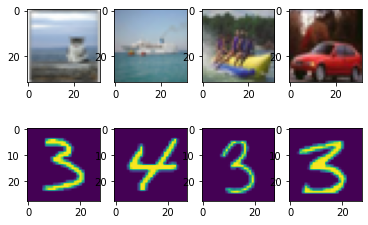

In [2]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds

# CIFAR-10数据集加载路径
DATA_DIR_CIFAR10 = "./datasets/cifar-10-batches-bin/"
# MNIST数据集加载路径
DATA_DIR_MNIST = "./mnist/"

# 加载CIFAR-10数据集，选取4张图片
dataset_cifar10 = ds.Cifar10Dataset(DATA_DIR_CIFAR10, num_samples=4)
# 加载MNIST数据集，选取4张图片
dataset_mnist = ds.MnistDataset(DATA_DIR_MNIST, num_samples=4)

# 显示选取的图像
num = 0
for data1, data2 in zip(dataset_cifar10.create_dict_iterator(), dataset_mnist.create_dict_iterator()):
    plt.subplot(2, 4, num + 1)
    plt.imshow(data1['image'].asnumpy())
    plt.subplot(2, 4, num + 5)
    plt.imshow(data2['image'].asnumpy())
    num = num + 1

# 显示图像
plt.show()

## c_transforms模块

`c_transforms`是基于C++的OpenCV实现，提供了多种图像增强功能，具有较高的性能。

### RandomCrop

`RandomCrop`操作对输入图像进行在随机位置的裁剪。

参数说明：

- `size`：裁剪图像的尺寸。

- `padding`：填充的像素数量。

- `pad_if_needed`：原图小于裁剪尺寸时，是否需要填充。

- `fill_value`：在常量填充模式时使用的填充值。

- `padding_mode`：填充模式。

下面的样例首先使用顺序采样器加载[CIFAR-10数据集[1]](#参考文献)，然后对已加载的图片进行长宽均为10的随机裁剪，最后输出裁剪前后的图片形状及对应标签，并对图片进行了展示。

Source image Shape : (32, 32, 3) , Source label : 6
Cropped image Shape: (10, 10, 3) , Cropped label: 6
------
Source image Shape : (32, 32, 3) , Source label : 9
Cropped image Shape: (10, 10, 3) , Cropped label: 9
------
Source image Shape : (32, 32, 3) , Source label : 9
Cropped image Shape: (10, 10, 3) , Cropped label: 9
------


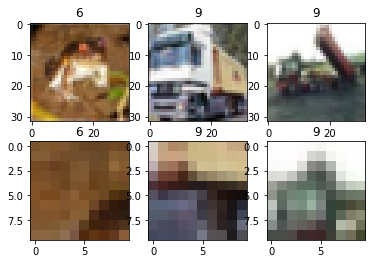

In [3]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as c_trans

ds.config.set_seed(5)
ds.config.set_num_parallel_workers(1)

# CIFAR-10数据集加载路径
DATA_DIR = "./datasets/cifar-10-batches-bin/"

# 使用SequentialSampler采样器选取3张图片
sampler = ds.SequentialSampler(num_samples=3)
dataset1 = ds.Cifar10Dataset(DATA_DIR, sampler=sampler)

# 使用RandomCrop对原图进行10*10随机裁剪操作
random_crop = c_trans.RandomCrop([10, 10])
dataset2 = dataset1.map(operations=random_crop, input_columns=["image"])

image_list1, label_list1 = [], []
image_list2, label_list2 = [], []

# 打印随机裁剪操作前后图片的形状、标签
for data1, data2 in zip(dataset1.create_dict_iterator(), dataset2.create_dict_iterator()):
    image_list1.append(data1['image'])
    label_list1.append(data1['label'])
    print("Source image Shape :", data1['image'].shape, ", Source label :", data1['label'])
    image_list2.append(data2['image'])
    label_list2.append(data2['label'])
    print("Cropped image Shape:", data2['image'].shape, ", Cropped label:", data2['label'])
    print("------")

# 规划显示画布，为显示图像做准备
num_samples = len(image_list1) + len(image_list2)
for i in range(num_samples):
    if i < len(image_list1):
        plt.subplot(2, len(image_list1), i + 1)
        plt.imshow(image_list1[i].asnumpy())
        plt.title(label_list1[i].asnumpy())
    else:
        plt.subplot(2, len(image_list2), i + 1)
        plt.imshow(image_list2[i % len(image_list2)].asnumpy())
        plt.title(label_list2[i % len(image_list2)].asnumpy())

# 显示图像
plt.show()

从上面的打印和图片显示结果可以看出，图片随机裁剪前后，标签不变，形状发生了变化。裁剪前的图片分辨率为32×32，裁剪后为10×10。

### RandomHorizontalFlip

`RandomHorizontalFlip`操作对输入图像进行随机水平翻转。

参数说明：

- `prob`: 单张图片发生翻转的概率。

下面的样例首先使用随机采样器加载[CIFAR-10数据集[1]](#参考文献)，然后对已加载的图片进行概率为0.8的随机水平翻转，最后输出翻转前后的图片形状及对应标签，并对图片进行了展示。

Source image Shape : (32, 32, 3) , Source label : 3
Flipped image Shape: (32, 32, 3) , Flipped label: 3
------
Source image Shape : (32, 32, 3) , Source label : 6
Flipped image Shape: (32, 32, 3) , Flipped label: 6
------
Source image Shape : (32, 32, 3) , Source label : 6
Flipped image Shape: (32, 32, 3) , Flipped label: 6
------
Source image Shape : (32, 32, 3) , Source label : 9
Flipped image Shape: (32, 32, 3) , Flipped label: 9
------


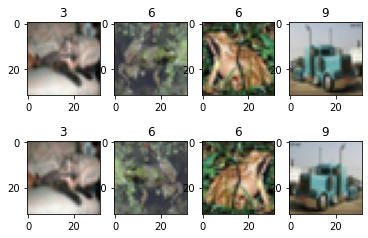

In [4]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as c_trans

ds.config.set_seed(6)
ds.config.set_num_parallel_workers(1)

# CIFAR-10数据集加载路径
DATA_DIR = "./datasets/cifar-10-batches-bin/"

# 使用RandomSampler采样器随机选取4张图片
sampler = ds.RandomSampler(num_samples=4)
dataset1 = ds.Cifar10Dataset(DATA_DIR, sampler=sampler)

# 使用RandomHorizontalFlip对原图进行随机水平翻转
random_horizontal_flip = c_trans.RandomHorizontalFlip(prob=0.8)
dataset2 = dataset1.map(operations=random_horizontal_flip, input_columns=["image"])

# 打印随机水平翻转前后图片的形状、标签
image_list1, label_list1 = [], []
image_list2, label_list2 = [], []
for data1, data2 in zip(dataset1.create_dict_iterator(), dataset2.create_dict_iterator()):
    image_list1.append(data1['image'])
    label_list1.append(data1['label'])
    print("Source image Shape :", data1['image'].shape, ", Source label :", data1['label'])
    image_list2.append(data2['image'])
    label_list2.append(data2['label'])
    print("Flipped image Shape:", data2['image'].shape, ", Flipped label:", data2['label'])
    print("------")

# 规划显示画布，为显示图像做准备
num_samples = len(image_list1) + len(image_list2)
for i in range(num_samples):
    if i < len(image_list1):
        plt.subplot(2, len(image_list1), i + 1)
        plt.imshow(image_list1[i].asnumpy())
        plt.title(label_list1[i].asnumpy())
    else:
        plt.subplot(2, len(image_list2), i + 1)
        plt.imshow(image_list2[i % len(image_list2)].asnumpy())
        plt.title(label_list2[i % len(image_list2)].asnumpy())

# 显示图像
plt.show()

从上面的打印和图片显示结果可以看出，经过随机水平翻转操作后，图像的形状、标签均未发生变化，部分图片被水平翻转。

### Resize

`Resize`操作对输入图像进行缩放。

参数说明：

- `size`：缩放的目标大小。
- `interpolation`：缩放时采用的插值方式。

下面的样例首先加载[MNIST数据集[2]](#参考文献)，然后将已加载的图片缩放至(101, 101)大小，最后输出缩放前后的图片形状及对应标签，并对图片进行了展示。

Source image Shape : (28, 28, 1) , Source label : 5
Resized image Shape: (101, 101, 1) , Resized label: 5
------
Source image Shape : (28, 28, 1) , Source label : 0
Resized image Shape: (101, 101, 1) , Resized label: 0
------
Source image Shape : (28, 28, 1) , Source label : 4
Resized image Shape: (101, 101, 1) , Resized label: 4
------
Source image Shape : (28, 28, 1) , Source label : 1
Resized image Shape: (101, 101, 1) , Resized label: 1
------


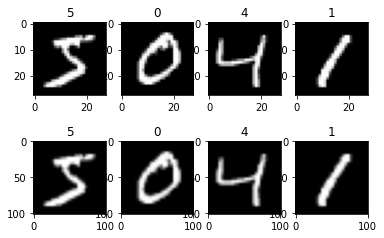

In [5]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as c_trans

# MNIST数据集加载路径
DATA_DIR = "./mnist/"

# 加载MNIST数据集，选取4张图片
dataset1 = ds.MnistDataset(DATA_DIR, num_samples=4, shuffle=False)

# 使用Resize操作对图像进行101×101缩放
resize = c_trans.Resize(size=[101, 101])
dataset2 = dataset1.map(operations=resize, input_columns=["image"])

# 打印缩放前后图片的形状、标签
image_list1, label_list1 = [], []
image_list2, label_list2 = [], []
for data1, data2 in zip(dataset1.create_dict_iterator(), dataset2.create_dict_iterator()):
    image_list1.append(data1['image'])
    label_list1.append(data1['label'])
    print("Source image Shape :", data1['image'].shape, ", Source label :", data1['label'])
    image_list2.append(data2['image'])
    label_list2.append(data2['label'])
    print("Resized image Shape:", data2['image'].shape, ", Resized label:", data2['label'])
    print("------")

# 规划显示画布，为显示图像做准备
num_samples = len(image_list1) + len(image_list2)
for i in range(num_samples):
    if i < len(image_list1):
        plt.subplot(2, len(image_list1), i + 1)
        plt.imshow(image_list1[i].asnumpy().squeeze(), cmap=plt.cm.gray)
        plt.title(label_list1[i].asnumpy())
    else:
        plt.subplot(2, len(image_list2), i + 1)
        plt.imshow(image_list2[i % len(image_list2)].asnumpy().squeeze(), cmap=plt.cm.gray)
        plt.title(label_list2[i % len(image_list2)].asnumpy())

# 显示图像
plt.show()

从上面的打印和图片显示结果可以看出，缩放前后，图片的形状发生了变化，标签未变。缩放前图片分辨率为28×28，缩放后，图片分辨率为101×101。

### Invert

`Invert`操作对输入图像进行反相处理。

下面的样例首先加载[CIFAR-10数据集[1]](#参考文献)，然后定义反相操作并作用于已加载的图片，最后输出反相前后的图片形状和标签，并对图片进行展示。

Source image Shape : (32, 32, 3) , Source label : 4
Inverted image Shape: (32, 32, 3) , Inverted label: 4
------
Source image Shape : (32, 32, 3) , Source label : 9
Inverted image Shape: (32, 32, 3) , Inverted label: 9
------
Source image Shape : (32, 32, 3) , Source label : 6
Inverted image Shape: (32, 32, 3) , Inverted label: 6
------
Source image Shape : (32, 32, 3) , Source label : 5
Inverted image Shape: (32, 32, 3) , Inverted label: 5
------


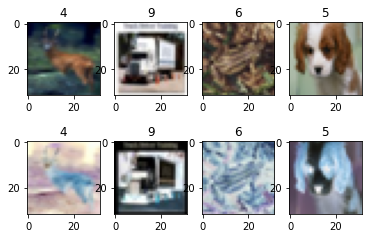

In [6]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as c_trans

ds.config.set_seed(8)

# CIFAR-10数据集加载路径
DATA_DIR = "./datasets/cifar-10-batches-bin/"

# 加载CIFAR-10数据集，选取4张图片
dataset1 = ds.Cifar10Dataset(DATA_DIR, num_samples=4, shuffle=True)

# 对图片进行反相操作
invert = c_trans.Invert()
dataset2 = dataset1.map(operations=invert, input_columns=["image"])

# 打印反相操作前后图片的形状、标签
image_list1, label_list1 = [], []
image_list2, label_list2 = [], []
for data1, data2 in zip(dataset1.create_dict_iterator(), dataset2.create_dict_iterator()):
    image_list1.append(data1['image'])
    label_list1.append(data1['label'])
    print("Source image Shape :", data1['image'].shape, ", Source label :", data1['label'])
    image_list2.append(data2['image'])
    label_list2.append(data2['label'])
    print("Inverted image Shape:", data2['image'].shape, ", Inverted label:", data2['label'])
    print("------")

# 规划显示画布，为显示图像做准备
num_samples = len(image_list1) + len(image_list2)
for i in range(num_samples):
    if i < len(image_list1):
        plt.subplot(2, len(image_list1), i + 1)
        plt.imshow(image_list1[i].asnumpy().squeeze(), cmap=plt.cm.gray)
        plt.title(label_list1[i].asnumpy())
    else:
        plt.subplot(2, len(image_list2), i + 1)
        plt.imshow(image_list2[i % len(image_list2)].asnumpy().squeeze(), cmap=plt.cm.gray)
        plt.title(label_list2[i % len(image_list2)].asnumpy())

# 显示图像
plt.show()

从上面的打印和图片显示结果可以看出，反相操作前后，图片的形状和标签未变，颜色发生了变化。

## py_transforms模块

### Compose

`Compose`操作接收一个`transforms`列表，将列表中的数据增强操作依次作用于数据集图片。

下面的样例首先加载[CIFAR-10数据集[1]](#参考文献)，然后同时定义解码、缩放和数据类型转换操作，并作用于已加载的图片，最后输出处理后的图片形状及对应标签，并对图片进行展示。

Transformed image Shape: (3, 200, 200) , Transformed label: 4
Transformed image Shape: (3, 200, 200) , Transformed label: 9
Transformed image Shape: (3, 200, 200) , Transformed label: 6
Transformed image Shape: (3, 200, 200) , Transformed label: 5
Transformed image Shape: (3, 200, 200) , Transformed label: 7


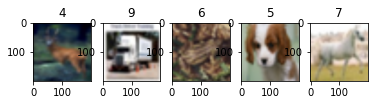

In [7]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision.py_transforms as py_trans
from mindspore.dataset.transforms.py_transforms import Compose
from PIL import Image

ds.config.set_seed(8)

# CIFAR-10数据集加载路径
DATA_DIR = "./datasets/cifar-10-batches-bin/"

# 加载CIFAR-10数据集，选取4张图片
dataset1 = ds.Cifar10Dataset(DATA_DIR, num_samples=5, shuffle=True)

# 定义解码函数
def decode(image):
    return Image.fromarray(image)

# 定义transforms列表
transforms_list = [
    decode,
    py_trans.Resize(size=(200, 200)),
    py_trans.ToTensor()
]

# 通过Compose操作将transforms列表中函数作用于数据集图片
compose_trans = Compose(transforms_list)
dataset2 = dataset1.map(operations=compose_trans, input_columns=["image"])

# 打印数据增强操作后图片的形状、标签
image_list, label_list = [], []
for data in dataset2.create_dict_iterator():
    image_list.append(data['image'])
    label_list.append(data['label'])
    print("Transformed image Shape:", data['image'].shape, ", Transformed label:", data['label'])

# 规划显示画布，为显示图像做准备
num_samples = len(image_list)
for i in range(num_samples):
    plt.subplot(1, len(image_list), i + 1)
    plt.imshow(image_list[i].asnumpy().transpose(1, 2, 0))
    plt.title(label_list[i].asnumpy())

# 显示图像
plt.show()

从上面的打印和图片显示结果可以看出，经过transforms列表中的数据增强操作后，图片标签未变，形状发生了变化，分辨率缩放为200×200。

## 使用注意事项

在数据管道处理模式中，请谨慎混用`c_transforms`与`py_transforms`，因为两者在数据的计算管道（即Pipeline）中运行的方式存在差异。

混用会引发C++与Python切换的成本，从而降低处理性能，因此建议尽量不要过度混用两个模块的算子。

> 注：Eager模式混用`c_transforms`与`py_transforms`不受运行方式差异影响

### 推荐的使用方式

1. 优先推荐单独使用`py_transform`或`c_transform`。如下图所示，不存在Python层和C++层切换使用的情况。

    ![tranform-c-py1](https://gitee.com/mindspore/docs/raw/tutorials-develop/tutorials/source_zh_cn/advance/dataset/images/transform_recommended_1.png)

2. 先使用`py_transform`，再使用`c_transform`。如下图所示，先完成Python层的操作后，再完成C++层的操作。

    ![tranform-c-py2](https://gitee.com/mindspore/docs/raw/tutorials-develop/tutorials/source_zh_cn/advance/dataset/images/transform_recommended_2.png)

3. 先使用`c_transform`，再使用`py_transform`。如下图所示，先完成C++层的操作后，再完成Python层的操作。

    ![tranform-c-py3](https://gitee.com/mindspore/docs/raw/tutorials-develop/tutorials/source_zh_cn/advance/dataset/images/transform_recommended_3.png)

### 不推荐的使用方式

在两种transform之间频繁切换。如下图所示，这种在Python层和C++层来回切换的使用方式是极不推荐的。

![tranform-c-py4](https://gitee.com/mindspore/docs/raw/tutorials-develop/tutorials/source_zh_cn/advance/dataset/images/transform_not_recommended.png)

## 参考文献

[1] Alex Krizhevsky. [Learning_Multiple Layers of Features from Tiny Images](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf).

[2] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf).